In [1]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import datetime
import gc
import glob
import os
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split


EMO_COLUMNS = ["pad_pleasure", "pad_arousal", "pad_dominance", "preview_pad_pleasure", "preview_pad_arousal", "preview_pad_dominance", "emo_aerger", "emo_erwarten", "emo_ekel", "emo_furcht", "emo_freude", "emo_traurigkeit", "emo_ueberraschung", "emo_vertrauen", "preview_emo_aerger", "preview_emo_erwarten", "preview_emo_ekel", "preview_emo_furcht", "preview_emo_freude", "preview_emo_traurigkeit", "preview_emo_ueberraschung", "preview_emo_vertrauen"]
PLAIN_TEXT_COLUMNS = ["article_header", "article_teaser", "article_full_text", "article_preview_emotion"]
COLUMNS_TO_DROP = ["published_at_local", "modified_at_local", "publisher_id"]
ARTICLE_DATA_PATH = "data/Drive Daten/students_articles_enriched_1.parquet.gzip"
PAGEVIEW_DATA_PATH = "data/Drive Daten/students_pageviews_2021-01-02.parquet.gzip"

gc.collect()

def get_first_batch(path):
    parquet_file = pq.ParquetFile(path)
    for batch in parquet_file.iter_batches():
        return batch.to_pandas()
def get_all_batches(path):
    parquet_file = pq.ParquetFile(path)
    return pd.concat([batch.to_pandas() for batch in parquet_file.iter_batches()])

def patch_article_full_text(df):
    df["ARI"] = df["article_full_text"].apply(lambda x: x.replace("\n", " ")).apply(lambda x:ARI(x))
    df = df.drop(columns=PLAIN_TEXT_COLUMNS)
    df[["topic", "locality", "newstype", "genre"]] = df[["topic", "locality", "newstype", "genre"]].fillna("")
    df[EMO_COLUMNS] = df[EMO_COLUMNS].fillna(0)
    df[["is_plus_article"]] = df[["is_plus_article"]].fillna(False)
    return df

# Calculate text complexity using rounded ARI
def ARI(text):
    score = 0.0 
    if len(text) > 0:
        score = round(4.71 * (len(text) / len(text.split()) ) +  0.5 * ( len(text.split()) / len(text.split('.'))) - 21.43)
        return score if score > 0 else 0

In [2]:
article_data = patch_article_full_text(get_all_batches(ARTICLE_DATA_PATH))
pageview_data = pd.concat([get_first_batch(f) for f in glob.glob(f"{os.getcwd()}/data/Drive Daten/students_pageviews*.gzip")][:50])
pageview_data = get_first_batch(PAGEVIEW_DATA_PATH)

In [3]:
pageview_data_grouped = pageview_data[["article_drive_id", "time_engaged_in_s"]].groupby(["article_drive_id"]).sum(["time_engaged_in_s"]).reset_index()

merged_data = pd.merge(article_data, pageview_data_grouped, on="article_drive_id")
merged_data["is_plus_article"].fillna(False, inplace=True)
merged_data = pd.merge(merged_data, pageview_data[["article_drive_id", "portal_id"]], on="article_drive_id")

In [4]:
merged_data.columns

Index(['publisher_id', 'article_drive_id', 'is_plus_article', 'is_dpa',
       'published_at_local', 'modified_at_local', 'pad_pleasure',
       'pad_arousal', 'pad_dominance', 'preview_pad_pleasure',
       'preview_pad_arousal', 'preview_pad_dominance', 'emo_aerger',
       'emo_erwarten', 'emo_ekel', 'emo_furcht', 'emo_freude',
       'emo_traurigkeit', 'emo_ueberraschung', 'emo_vertrauen',
       'preview_emo_aerger', 'preview_emo_erwarten', 'preview_emo_ekel',
       'preview_emo_furcht', 'preview_emo_freude', 'preview_emo_traurigkeit',
       'preview_emo_ueberraschung', 'preview_emo_vertrauen',
       'article_header_contains_quote', 'article_header_contains_question',
       'article_header_contains_doppelpunkt',
       'article_header_contains_pronoun_writer',
       'article_header_contains_pronoun_reader',
       'article_preview_contains_quote', 'article_preview_contains_question',
       'article_preview_contains_doppelpunkt',
       'article_preview_contains_pronoun_write

In [5]:
print(merged_data.portal_id.unique())
print(merged_data.topic.unique())
print(merged_data.locality.unique())
print(merged_data.newstype.unique())
print(merged_data.genre.unique())

['portal_1' 'portal_31' 'portal_17' 'portal_3' 'portal_2']
['Vermischtes: Gesundheit' 'Justiz/Kriminalität' 'Vermischtes: Religion'
 'Vermischtes: Soziales' 'Verkehr/Infrastruktur' '' 'Kultur'
 'Vermischtes: Sonstiges' 'Vermischtes: Leute' 'Wirtschaft: Unternehmen'
 'Vermischtes: Freizeit/Hobbys' 'Sport: Fußball' 'Politik'
 'Katastrophe/Unglück' 'Sport: Nicht-Fußball' 'Vermischtes: Wissenschaft'
 'Bildung/Erziehung' 'Wirtschaft: Verbraucher']
['National' 'Lokal (Lokalausgabe)' 'Regional (Verbreitungsgebiet)' ''
 'International']
['News to Know' 'News to Entertain' '' 'News to Use']
['Nachrichten/Bericht' 'Meinung' 'Ratgeber/Service' ''
 'Reportage/Storytelling' 'Kurzmeldung' 'Porträt' 'Interview'
 'Newsblog/Ticker']


/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.911970190964136


<AxesSubplot:ylabel='Count'>

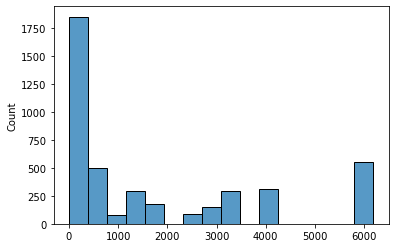

In [6]:
merged_data_cleaned_no_dummies = merged_data.drop(columns=COLUMNS_TO_DROP)
features = list(filter(lambda x: x not in ["time_engaged_in_s", "article_drive_id"], merged_data_cleaned_no_dummies.columns))
merged_data_cleaned_no_dummies_no_na = merged_data_cleaned_no_dummies.dropna()
X, y = pd.get_dummies(merged_data_cleaned_no_dummies_no_na[features]), merged_data_cleaned_no_dummies_no_na["time_engaged_in_s"].array
X_train, X_test, y_train, y_test = train_test_split(X, y)
svm = LinearSVC()
svm.fit(X_train, y_train)
print(svm.score(X_test, y_test))
y_pred = svm.predict(X_test)
sns.histplot(y_pred)

In [10]:
print(X.columns)

Index(['is_plus_article', 'is_dpa', 'pad_pleasure', 'pad_arousal',
       'pad_dominance', 'preview_pad_pleasure', 'preview_pad_arousal',
       'preview_pad_dominance', 'emo_aerger', 'emo_erwarten', 'emo_ekel',
       'emo_furcht', 'emo_freude', 'emo_traurigkeit', 'emo_ueberraschung',
       'emo_vertrauen', 'preview_emo_aerger', 'preview_emo_erwarten',
       'preview_emo_ekel', 'preview_emo_furcht', 'preview_emo_freude',
       'preview_emo_traurigkeit', 'preview_emo_ueberraschung',
       'preview_emo_vertrauen', 'article_header_contains_quote',
       'article_header_contains_question',
       'article_header_contains_doppelpunkt',
       'article_header_contains_pronoun_writer',
       'article_header_contains_pronoun_reader',
       'article_preview_contains_quote', 'article_preview_contains_question',
       'article_preview_contains_doppelpunkt',
       'article_preview_contains_pronoun_writer',
       'article_preview_contains_pronoun_reader', 'ARI', 'topic_',
       'topic_B

In [8]:
from joblib import dump
dump(svm, "LocalModel.joblib")

['LocalModel.joblib']